In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,datetime,time

import torch
import modin.pandas as pd
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('../../TF_data/nCovid19/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')

In [3]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,129,149,149,197,238,428,566,673,790,900


In [4]:
df = df.drop(columns=['Province/State','Lat','Long']).transpose()

In [5]:
df.columns = df.iloc[0]

In [6]:
df = df.drop(index=['Country/Region'])

To request implementation, send an email to feature_requests@modin.org.


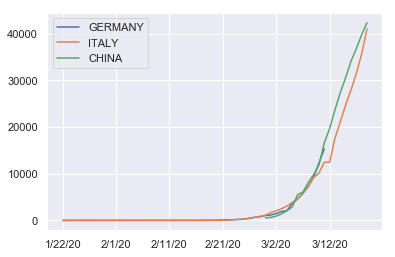

In [7]:
ax = df['Germany'].shift(periods=-8).plot(legend=True)
df['Italy'].plot(ax=ax,legend=True)
df['China'].sum(axis=1).shift(periods=38).plot(ax=ax,legend=True)

ax.legend(['GERMANY','ITALY','CHINA'])

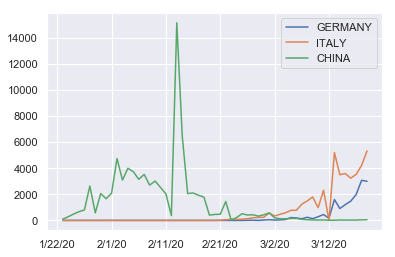

In [8]:
ax = df['Germany'].diff().plot(legend=True)
df['Italy'].diff().plot(ax=ax,legend=True)
df['China'].sum(axis=1).diff().plot(ax=ax,legend=True)

ax.legend(['GERMANY','ITALY','CHINA'])

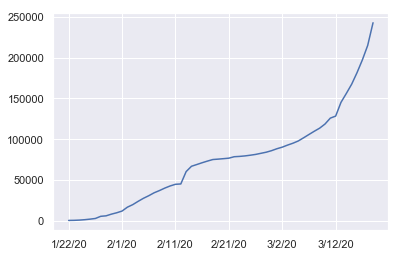

In [9]:
df.sum(axis=1).plot()

In [10]:
df0 = df[['Germany','Italy']]
df0['China'] = df['China'].sum(axis=1)

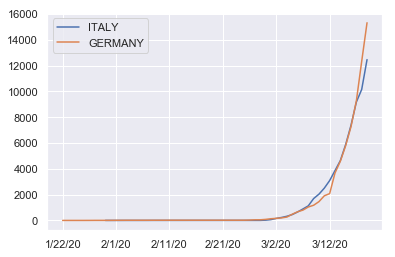

In [11]:
# Difference Italy-Germany should be around 8 days

ax = df0['Italy'].shift(periods=8).plot(legend=True)
df0['Germany'].plot(ax=ax,legend=True)

ax.legend(['ITALY','GERMANY'])

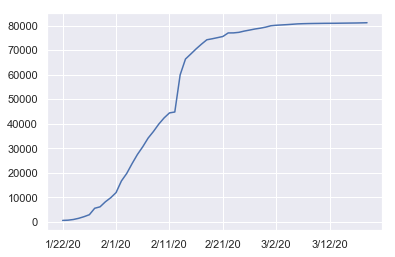

In [12]:
df0['China'].plot()

In [27]:
from scipy.optimize import curve_fit

def exp_fn(x,a,k,b): return a*np.exp(k*x+b)

In [36]:
x = np.arange(0,df0['Germany'].values.shape[0])
y = df0['Germany'].values

In [43]:
popt_exp,pcov_exp = curve_fit(exp_fn,x,y.astype(np.float32),p0=[1,0,1])

In [48]:
df0['Germany Model'] = exp_fn(x,popt_exp[0],popt_exp[1],popt_exp[2])

In [51]:
popt_exp

array([ 0.01410304,  0.25282339, -0.49985064])

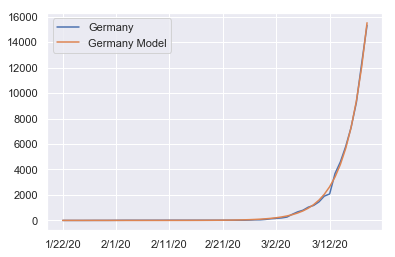

In [49]:
df0[['Germany','Germany Model']].plot()

In [50]:
x = np.arange(0,df0['Italy'].values.shape[0])
y = df0['Italy'].values

In [52]:
popt_exp,pcov_exp = curve_fit(exp_fn,x,y.astype(np.float32),p0=[1,0,1])

In [53]:
df0['Italy Model'] = exp_fn(x,popt_exp[0],popt_exp[1],popt_exp[2])

In [54]:
popt_exp

array([0.88495176, 0.15941205, 1.70129336])

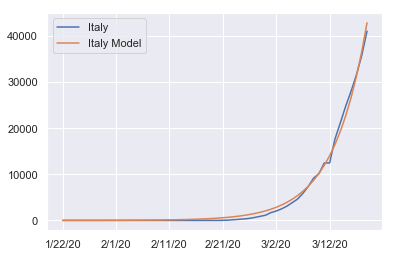

In [55]:
df0[['Italy','Italy Model']].plot()

In [56]:
x = np.arange(0,df0['China'].values.shape[0])
y = df0['China'].values

popt_exp,pcov_exp = curve_fit(exp_fn,x,y.astype(np.float32),p0=[1,0,1])

df0['China Model'] = exp_fn(x,popt_exp[0],popt_exp[1],popt_exp[2])

In [59]:
popt_exp

array([7.29173915e+01, 2.42600754e-02, 5.87845616e+00])

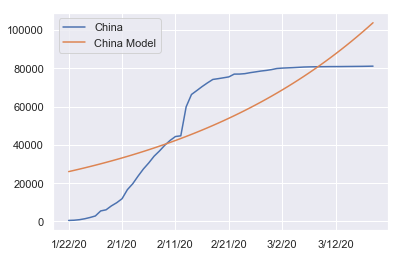

In [60]:
df0[['China','China Model']].plot()

In [93]:
def sigmoid_fn(x,k,b,T): return T*(np.exp(k*x+b))/(1+np.exp(k*x+b))

In [94]:
x = np.arange(0,df0['China'].values.shape[0])
y = df0['China'].values

popt_sigmoid,pcov_sigmoid = curve_fit(sigmoid_fn,x,y.astype(np.float32),p0=[0,0,80000])

In [95]:
popt_sigmoid

array([ 2.22027776e-01, -3.94298863e+00,  8.09366498e+04])

In [96]:
df0['China Sigmoid Model'] = sigmoid_fn(x,
    popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2])

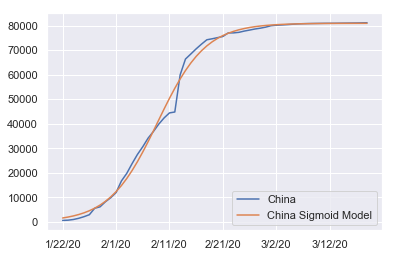

In [97]:
df0[['China','China Sigmoid Model']].plot()

In [111]:
x = np.arange(0,df0['Germany'].values.shape[0])
y = df0['Germany'].values

popt_sigmoid,pcov_sigmoid = curve_fit(sigmoid_fn,x,y.astype(np.float32),p0=[0,0,1000])

In [112]:
df0['Germany Sigmoid Model'] = sigmoid_fn(x,
    popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2])

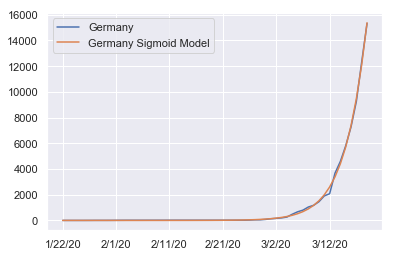

In [113]:
df0[['Germany','Germany Sigmoid Model']].plot()

In [114]:
popt_sigmoid

array([ 2.70614181e-01, -1.73200430e+01,  1.17696674e+05])

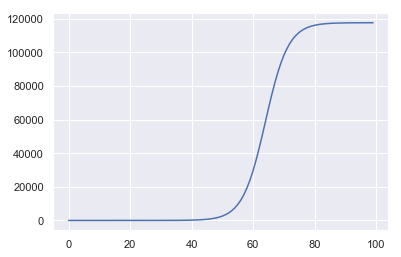

In [115]:
plt.plot(np.arange(0,100),sigmoid_fn(np.arange(0,100),popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2]))

In [104]:
df0['Germany'].shape

(58,)

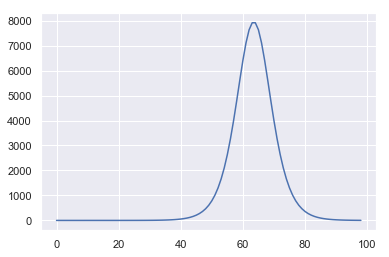

In [120]:
plt.plot(np.diff(sigmoid_fn(np.arange(0,100),popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2])))

In [105]:
x = np.arange(0,df0['Italy'].values.shape[0])
y = df0['Italy'].values

popt_sigmoid,pcov_sigmoid = curve_fit(sigmoid_fn,x,y.astype(np.float32),p0=[0,0,1000])

In [106]:
df0['Italy Sigmoid Model'] = sigmoid_fn(x,
    popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2])

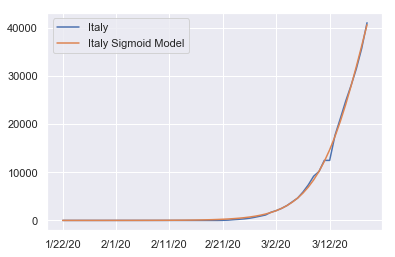

In [107]:
df0[['Italy','Italy Sigmoid Model']].plot()

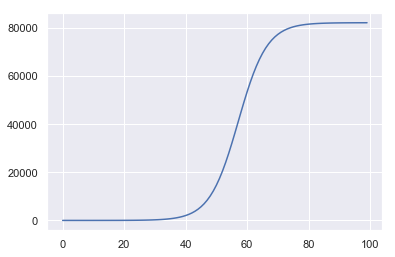

In [108]:
plt.plot(np.arange(0,100),sigmoid_fn(np.arange(0,100),popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2]))

In [110]:
df0['Italy'].shape

(58,)

In [141]:
popt_sigmoid,pcov_sigmoid = curve_fit(sigmoid_fn,np.arange(0,30),df0['China'][:30].values.astype(np.float32),[1,1,10])

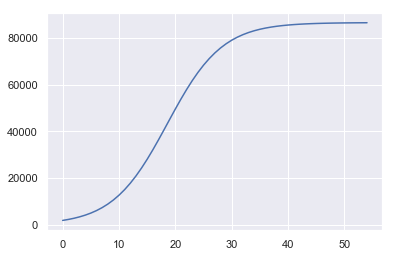

In [142]:
plt.plot(np.arange(0,55),sigmoid_fn(np.arange(0,55),popt_sigmoid[0],popt_sigmoid[1],popt_sigmoid[2]))